# Data Preprocessing on Expedia Hotel Dataset
This example is adapted from https://www.kaggle.com/ajay1216/practical-guide-on-data-preprocessing-in-python/notebook

# Preprocessing
Data preprocessing is a data mining technique that involves transforming raw data into an understandable format. Real-world data is often incomplete, inconsistent, and/or lacking in certain behaviors or trends, and is likely to contain many errors. Data preprocessing is a proven method of resolving such issues. Data preprocessing prepares raw data for further processing.

### Why preprocessing?

Real-world data are generally:

- **Incomplete**: lacking attribute values, lacking certain attributes of interest, or containing only aggregate data
- **Noisy**: containing errors or outliers
- **Inconsistent**: containing discrepancies in codes or names

Tasks in data preprocessing:

- **Data cleaning**: fill in missing values, smooth noisy data, identify or remove outliers, and resolve inconsistencies.
- **Data integration**: using multiple databases, data cubes, or files.
- **Data transformation**: normalization and aggregation.
- **Data reduction**: reducing the volume but producing the same or similar analytical results.
- **Data discretization**: part of data reduction, replacing numerical attributes with nominal ones.




#### What is Exploratory data analysis?
In statistics, exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.

#### Data Cleaning
Data cleaning is the process of cleaning / standardising the data to make it ready for analysis. Most of times, there will be discrepancies in the captured data such as incorrect data formats, missing data, errors while capturing the data. This is an important step in any given data science project because the accuracy of the results depends heavily on the data we use.

## Import  Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from io import StringIO
import io
import string
import random
import json
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import norm

### Dataset

- Dataset 2013-1014 time frame
- Train Data: 37 million entires
- Test Data: 2.5 million entries

Expedia has provided you logs of customer behavior. These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package. The data in this competition is a random selection from Expedia and is not representative of the overall statistics.

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

Your goal of this competition is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.

The train and test datasets are split based on time: training data from 2013 and 2014, while test data are from 2015. The public/private leaderboard data are split base on time as well. Training data includes all the users in the logs, including both click events and booking events. Test data only includes booking events. 

destinations.csv data consists of features extracted from hotel reviews text. 

Note that some srch_destination_id's in the train/test files don't exist in the destinations.csv file. This is because some hotels are new and don't have enough features in the latent space. Your algorithm should be able to handle this missing information.

In [2]:
# Load train data which has been subsampled to 100,000 rows.
train = pd.read_csv('train_subset.csv')

In [3]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [4]:
train.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_time                  100000 non-null  object 
 1   site_name                  100000 non-null  int64  
 2   posa_continent             100000 non-null  int64  
 3   user_location_country      100000 non-null  int64  
 4   user_location_region       100000 non-null  int64  
 5   user_location_city         100000 non-null  int64  
 6   orig_destination_distance  63078 non-null   float64
 7   user_id                    100000 non-null  int64  
 8   is_mobile                  100000 non-null  int64  
 9   is_package                 100000 non-null  int64  
 10  channel                    100000 non-null  int64  
 11  srch_ci                    99929 non-null   object 
 12  srch_co                    99929 non-null   object 
 13  srch_adults_cnt            100

#### Features

|  Feature |  Description | 
|----------|:---------|
| date_time  | Timestamp     |
| site_name | ID of Expedia point of sale|
| posa_continent | ID of site’s continent |
| user_location_country |ID of customer’s country |
| user_location_region|ID of customer’s region |
| user_location_city| ID of customer’s city|
| orig_destination_distance| Physical distance between a hotel and a customer|
| user_id| ID of user|
| is_mobile| 1 for mobile device, 0 otherwise|
| is_package| 1 if booking/click was part of package, 0 otherwise|
| channel| ID of a marketing channel|
| srch_ci| Check-in date|
| srch_co| Check-out date|
| srch_adults_cnt| Number of adults|
| srch_children_cnt| Number of children|
| srch_rm_cnt| Number of rooms|
| srch_destination_id| ID of the destination|
| srch_destination_type_id| Type of destination|
| is_booking | 1 if a booking, 0 if a click|
| cnt| Number of similar events in the context of the same user sessiont|
| hotel_continent| Hotel continent|
| hotel_country| Hotel country|
| hotel_market| Hotel market|
| hotel_cluster| ID of hotel cluster|


## Steps

first step was to clean and pre-process the data and perform exploratory analysis to get some interesting insights into the process of choosing a hotel.

- Remove the users who did not booked the hotel
- Identify the searches by each user belonging to a specific type of destination
- orig_destination_distance contains Nan values
- The  check-in  and  check-out  dates  to find the duration of the stay for each of the entries in the training set.



In [6]:
# Check the percentage of Nan in dataset
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train['hotel_cluster'].count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
orig_destination_distance,36922,0.36922
srch_ci,71,0.00071
srch_co,71,0.00071
channel,0,0.00000
site_name,0,0.00000
posa_continent,0,0.00000
user_location_country,0,0.00000
user_location_region,0,0.00000
user_location_city,0,0.00000
user_id,0,0.00000


## Visualization of Data


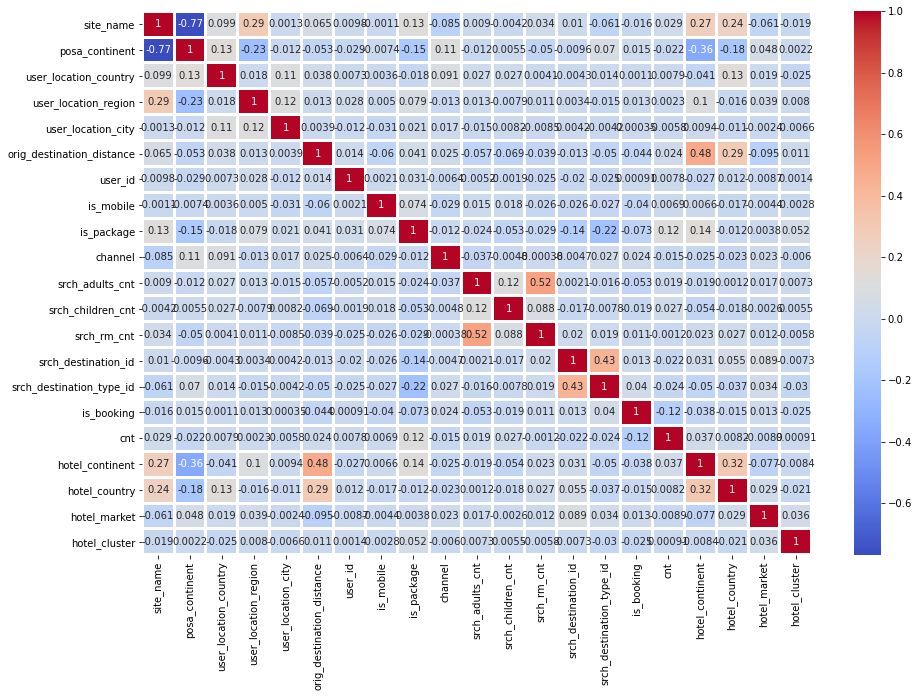

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(train.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2)

/home/dongryeol/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


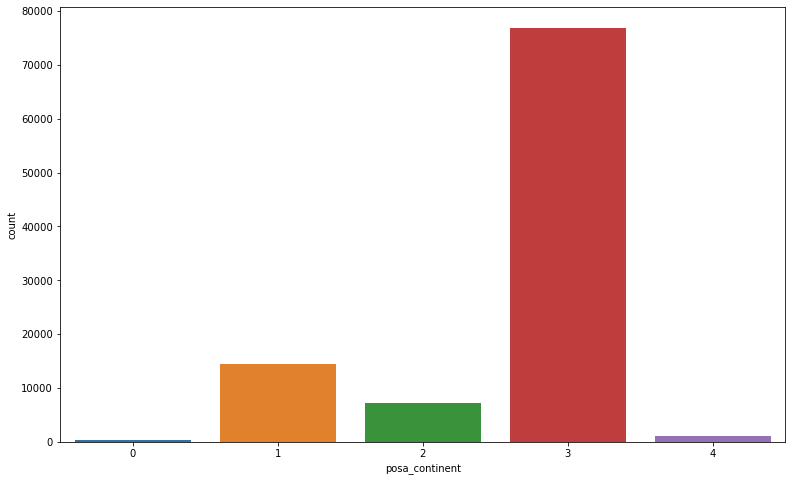

In [8]:
# Frequency of posa continent
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('posa_continent', data=train,order=[0,1,2,3,4],ax=ax)


/home/dongryeol/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


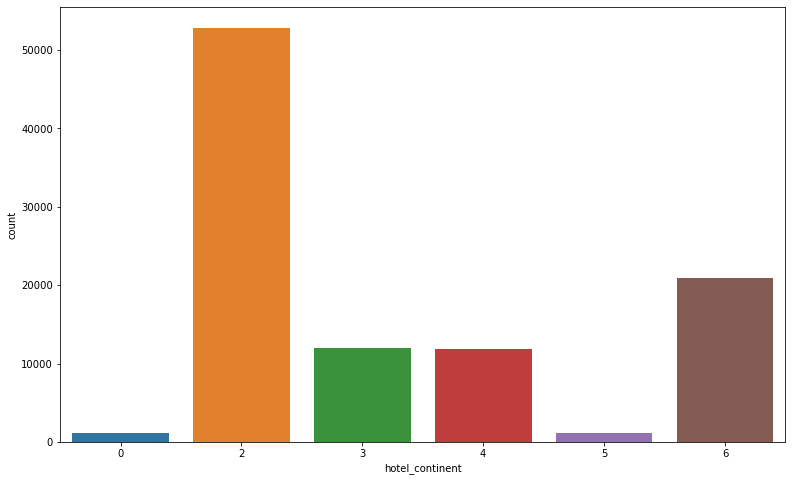

In [9]:
# frequency of hotel continent
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('hotel_continent', data=train,order=[0,2,3,4,5,6],ax=ax)


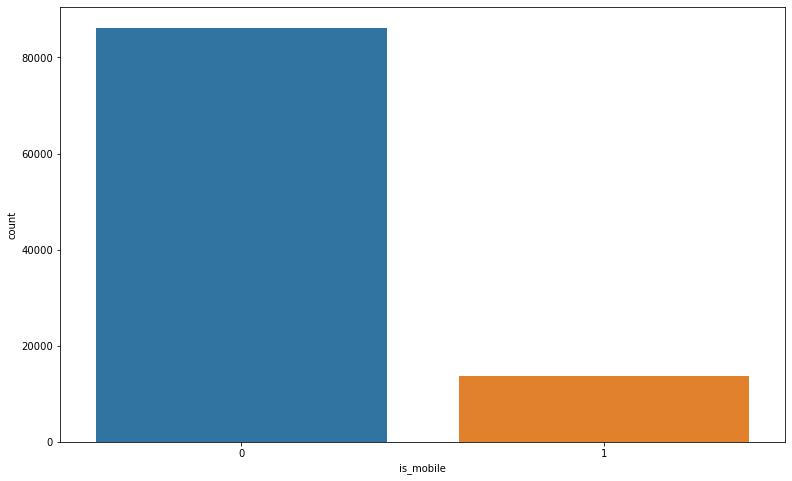

In [10]:
# Frequency of booking through mobile
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot(x='is_mobile',data=train, order=[0,1],ax=ax)


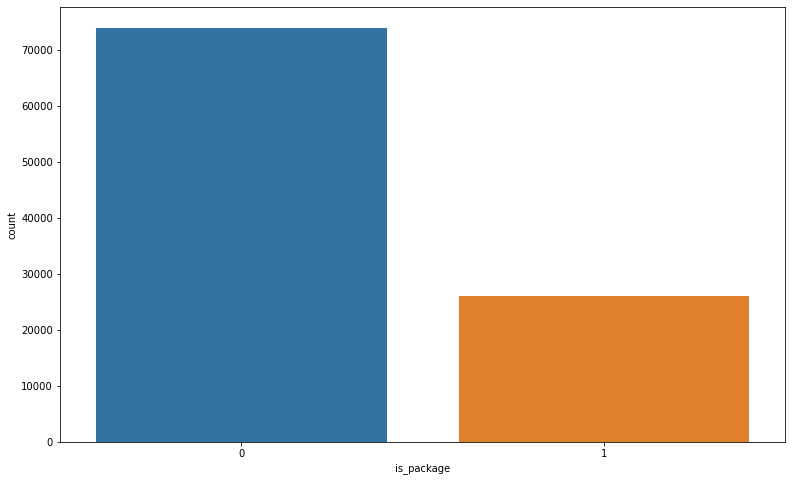

In [11]:
# frequency of bookings with package
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot(x='is_package',data=train, order=[0,1], ax=ax)

## Clean the Data

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_time                  100000 non-null  object 
 1   site_name                  100000 non-null  int64  
 2   posa_continent             100000 non-null  int64  
 3   user_location_country      100000 non-null  int64  
 4   user_location_region       100000 non-null  int64  
 5   user_location_city         100000 non-null  int64  
 6   orig_destination_distance  63078 non-null   float64
 7   user_id                    100000 non-null  int64  
 8   is_mobile                  100000 non-null  int64  
 9   is_package                 100000 non-null  int64  
 10  channel                    100000 non-null  int64  
 11  srch_ci                    99929 non-null   object 
 12  srch_co                    99929 non-null   object 
 13  srch_adults_cnt            100

### Convert it into numerical values which will be relevant to our model.
- date_time
- srch_ci
- srch_co




## Add Extra features
Extract relevant information from date columns
### Additional attributes
- stay_dur: number of duration of stay
- no_of_days_bet_booking: number of days between the booking and 
- Cin_day: Check-in day
- Cin_month: Check-in month
- Cin_year: Check-out year

In [13]:
# Function to convert date object into relevant attributes
def convert_date_into_days(df):
    df['srch_ci'] = pd.to_datetime(df['srch_ci'])
    df['srch_co'] = pd.to_datetime(df['srch_co'])
    df['date_time'] = pd.to_datetime(df['date_time'])
    
    df['stay_dur'] = (df['srch_co'] - df['srch_ci']).astype('timedelta64[D]')
    df['no_of_days_bet_booking'] = (df['srch_ci'] - df['date_time']).astype('timedelta64[D]')
    
    # For hotel check-in
    # Month, Year, Day
    df['Cin_day'] = df["srch_ci"].apply(lambda x: x.day)
    df['Cin_month'] = df["srch_ci"].apply(lambda x: x.month)
    df['Cin_year'] = df["srch_ci"].apply(lambda x: x.year)


In [14]:
convert_date_into_days(train)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date_time                  100000 non-null  datetime64[ns]
 1   site_name                  100000 non-null  int64         
 2   posa_continent             100000 non-null  int64         
 3   user_location_country      100000 non-null  int64         
 4   user_location_region       100000 non-null  int64         
 5   user_location_city         100000 non-null  int64         
 6   orig_destination_distance  63078 non-null   float64       
 7   user_id                    100000 non-null  int64         
 8   is_mobile                  100000 non-null  int64         
 9   is_package                 100000 non-null  int64         
 10  channel                    100000 non-null  int64         
 11  srch_ci                    99929 non-null   datetime6

/home/dongryeol/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


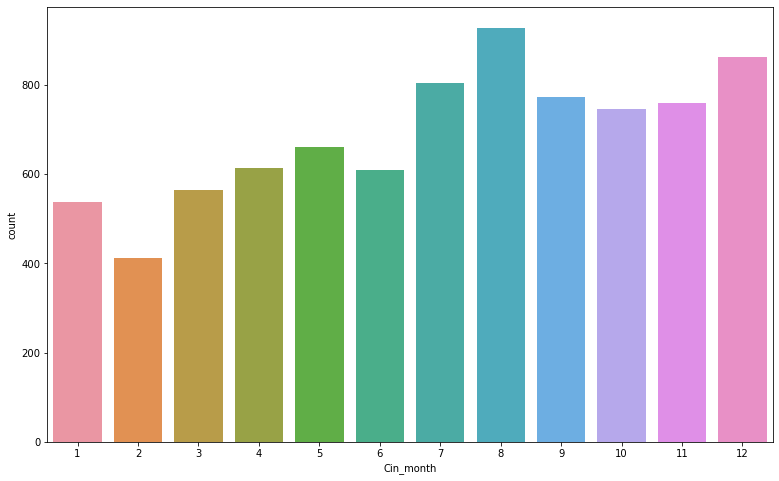

In [16]:
# Count the bookings in each month
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('Cin_month',data=train[train["is_booking"] == 1],order=list(range(1,13)),ax=ax)

/home/dongryeol/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


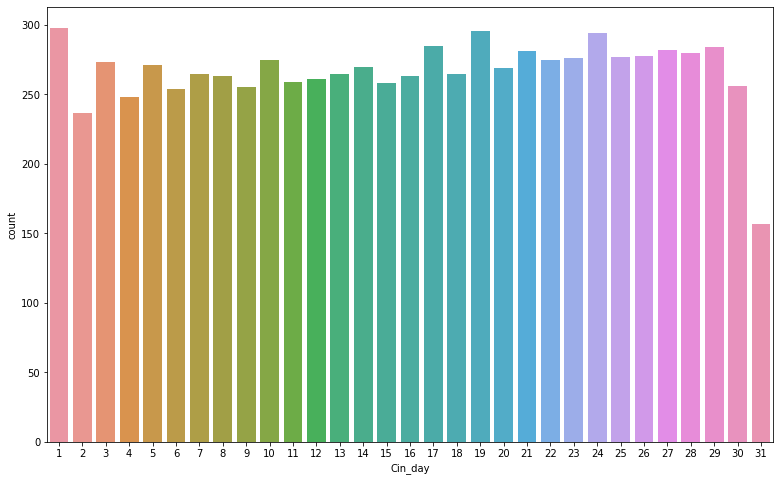

In [17]:
# Count the bookings as per the day
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('Cin_day',data=train[train["is_booking"] == 1],order=list(range(1,32)),ax=ax)

/home/dongryeol/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


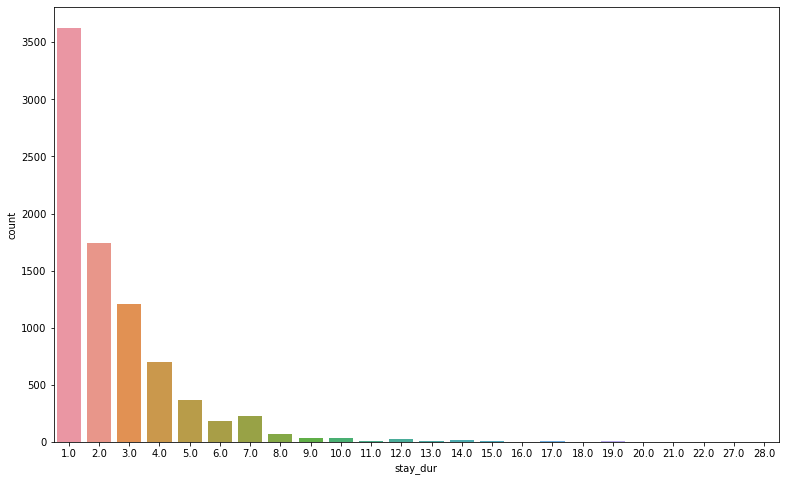

In [18]:
# Count the bookings as per the stay_duration
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('stay_dur',data=train[train["is_booking"] == 1],ax=ax)

In [19]:
# Check the percentage of Nan in dataset
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train['hotel_cluster'].count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
orig_destination_distance,36922,0.36922
Cin_year,71,0.00071
srch_ci,71,0.00071
Cin_month,71,0.00071
srch_co,71,0.00071
stay_dur,71,0.00071
no_of_days_bet_booking,71,0.00071
Cin_day,71,0.00071
site_name,0,0.00000
posa_continent,0,0.00000


### Fill nan with the day which has max occurence


In [20]:
#train['Cin_day'].value_counts() = 26
#train['Cin_month'].value_counts() = 8
#train['Cin_year'].value_counts() = 2014
#train['stay_dur'].value_counts() = 1
#train['no_of_days_bet_booking'].value_counts() = 0

In [21]:
train['Cin_day'] = train['Cin_day'].fillna(26.0)
train['Cin_month'] = train['Cin_month'].fillna(8.0)
train['Cin_year'] = train['Cin_year'].fillna(2014.0)
train['stay_dur'] = train['stay_dur'].fillna(1.0)
train['no_of_days_bet_booking'] = train['no_of_days_bet_booking'].fillna(0.0)

In [22]:
# Fill average values in place for nan, fill with mean
train['orig_destination_distance'].fillna(train['orig_destination_distance'].mean(), inplace=True)

In [23]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,stay_dur,no_of_days_bet_booking,Cin_day,Cin_month,Cin_year
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,3,2,50,628,1,4.0,15.0,27.0,8.0,2014.0
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,1,2,50,628,1,4.0,17.0,29.0,8.0,2014.0
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,1,2,50,628,1,4.0,17.0,29.0,8.0,2014.0
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,1,2,50,1457,80,5.0,105.0,23.0,11.0,2014.0
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,1,2,50,1457,21,5.0,105.0,23.0,11.0,2014.0


In [24]:
## Remove datetime object from the dataset
#columns to remove
user_id = train['user_id']
columns = ['date_time', 'srch_ci', 'srch_co','user_id','srch_destination_type_id','srch_destination_id']
train.drop(columns=columns,axis=1,inplace=True)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   site_name                  100000 non-null  int64  
 1   posa_continent             100000 non-null  int64  
 2   user_location_country      100000 non-null  int64  
 3   user_location_region       100000 non-null  int64  
 4   user_location_city         100000 non-null  int64  
 5   orig_destination_distance  100000 non-null  float64
 6   is_mobile                  100000 non-null  int64  
 7   is_package                 100000 non-null  int64  
 8   channel                    100000 non-null  int64  
 9   srch_adults_cnt            100000 non-null  int64  
 10  srch_children_cnt          100000 non-null  int64  
 11  srch_rm_cnt                100000 non-null  int64  
 12  is_booking                 100000 non-null  int64  
 13  cnt                        100

We have preprocessed our data and it is ready to fit into the model.
All the object values are converted into numerical values. Also, we have more insights of the data.